In [132]:


import torch as th
import torch.distributions as dist

import numpy as np

import networkx as nx

import pandas as pd

import matplotlib.pyplot as plt

class ProdGraph:
    def __init__(self, adjacency, distributions, initialization, buffer_limits):
        self.adjacency = th.tensor(adjacency)
        self.distributions = distributions
        
        G = nx.DiGraph(adjacency)
        topological_order = th.tensor(list(nx.topological_sort(G)))
        self.topological_order = topological_order
        
        self.remaining_time = th.zeros(adjacency.shape[0])
        self.states = th.zeros((adjacency.shape[0], adjacency.shape[0]))
        self.output_buffer = th.zeros(adjacency.shape[0])
        self.input_buffer = th.zeros(adjacency.shape[0])
        self.buffer_limits = th.tensor(buffer_limits)
        self.n_nodes = adjacency.shape[0]
                  
        
        
        # Initialize
        self.states = th.tensor(initialization)
        
        for i in range(self.n_nodes):
            self.remaining_time[i] = distributions[i].sample()
            if th.sum(self.adjacency[:, i]) == 0:
                self.input_buffer[i] = th.inf
                
        self.lapsed_time = 0
        
        self.log = pd.DataFrame({'time': [], 'node': [], 'state': [], 'input_buffer': [], 'output_buffer': []})
        
    def forward(self):
        
        # Define entry point
        remaining_time = th.where(self.states[:, 0] * self.remaining_time > 0, self.remaining_time, float('inf'))
        min_value, entry_index = th.min(remaining_time, dim=0)
        
        # Adjust times
        lapsed_time = min_value.item()
        self.remaining_time -= lapsed_time * self.states[:, 0]
        self.lapsed_time += lapsed_time
        
        # Get current topological order
        topological_index_entry_node = th.where(self.topological_order == entry_index)[0].item()
        current_topological_order = [self.topological_order[(topological_index_entry_node + i) % self.n_nodes] for i in range(self.n_nodes)]
        
        # Iterate through graph
        for node_index in current_topological_order:
            
            # Move supplies from output to input
            supply_vec = self.adjacency[:, node_index]
            if th.sum(supply_vec) > 0:
                num_supply_sets = th.min(th.nan_to_num(self.output_buffer / supply_vec, nan=float('inf')))
                if num_supply_sets >= 1 and self.input_buffer[node_index] == 0:
                    self.output_buffer -= supply_vec
                    self.input_buffer[node_index] = 1
                
            # Case producing
            if self.states[node_index, 0] == 1:
                # Check if this node 
                if self.remaining_time[node_index] == 0:
                    # Check if the part is finished
                    
                    if self.output_buffer[node_index] < self.buffer_limits[node_index]:
                        self.output_buffer[node_index] += 1
                        
                        if self.input_buffer[node_index] > 0:
                            # Start next part
                            self.remaining_time[node_index] = self.distributions[node_index].sample()
                            self.input_buffer[node_index] -= 1
                            self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 0}])])
                        else:
                            # Switch to starved
                            self.states[node_index, 0] = 0
                            self.states[node_index, 1] = 1
                            self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 1}])])
                    
                    else:
                        # Switch to blocked
                        self.states[node_index, 0] = 0
                        self.states[node_index, 2] = 1
                        self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 2}])])
                        
                
            # Case Starved 
            elif self.states[node_index, 1] == 1:
                # Check if supplies are now here
                if self.input_buffer[node_index] > 0:
                    #start producing
                    self.input_buffer[node_index] -= 1
                    self.remaining_time[node_index] = self.distributions[node_index].sample()
                    
                    # Switch to producing state
                    self.states[node_index, 0] = 1
                    self.states[node_index, 1] = 0
                    self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 0}])])
                
            # Case Blocked 
            elif self.states[node_index, 2] == 1:
                # Check if space in buffer
                if self.output_buffer[node_index] < self.buffer_limits[node_index]:
                    self.output_buffer[node_index] += 1
                    
                    if self.input_buffer[node_index] > 0:
                        # Start next part
                        self.remaining_time[node_index] = self.distributions[node_index].sample()
                        self.input_buffer[node_index] -= 1
                        
                        # Switch to producing state
                        self.states[node_index, 0] = 1
                        self.states[node_index, 2] = 0
                        self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 0}])])
                    else:
                        # Switch to starved
                        self.states[node_index, 1] = 1
                        self.states[node_index, 2] = 0
                        self.log = pd.concat([self.log, pd.DataFrame([{'time': self.lapsed_time, 'node': node_index.item(), 'input_buffer': self.input_buffer[node_index].item(), 'output_buffer': self.output_buffer[node_index].item(), 'state': 1}])])
                
            # Case Failure
            else:
                pass


In [143]:
adjacency_matrix = np.array([[0, 0, 1, 0],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1],
                             [0, 0, 0, 0]])

state_init_matrix = np.array([[1, 0, 0, 0],
                             [1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 1, 0, 0]])

buffer_limits = np.array([2, 2, 2, th.inf])

# for i in range (20):

#     dists = [dist.Uniform(30 + i, 30 - i), dist.Uniform(30 + i, 30 - i), dist.Uniform(30 + i, 30 - i), dist.Uniform(30 + i, 30 - i)]

#     graph = ProdGraph(adjacency_matrix, dists, state_init_matrix, buffer_limits)

#     while graph.lapsed_time < 1000:
#         graph.forward()
        
#     graph.log

dists = [dist.Uniform(6, 14), dist.Uniform(6, 14), dist.Uniform(6, 14), dist.Uniform(6, 14)]

graph = ProdGraph(adjacency_matrix, dists, state_init_matrix, buffer_limits)

while graph.lapsed_time < 10000:
    graph.forward()
    
graph.log

,time,node,state,input_buffer,output_buffer
0,8.088544,0.0,0.0,inf,1.0
0,10.137723,1.0,0.0,inf,1.0
0,10.137723,2.0,0.0,0.0,0.0
0,21.498651,1.0,0.0,inf,1.0
0,21.857343,0.0,0.0,inf,1.0
...,...,...,...,...,...
0,9995.635363,1.0,0.0,inf,2.0
0,9995.635363,2.0,0.0,0.0,2.0
0,9998.100055,0.0,0.0,inf,2.0
0,9998.166335,3.0,0.0,0.0,968.0


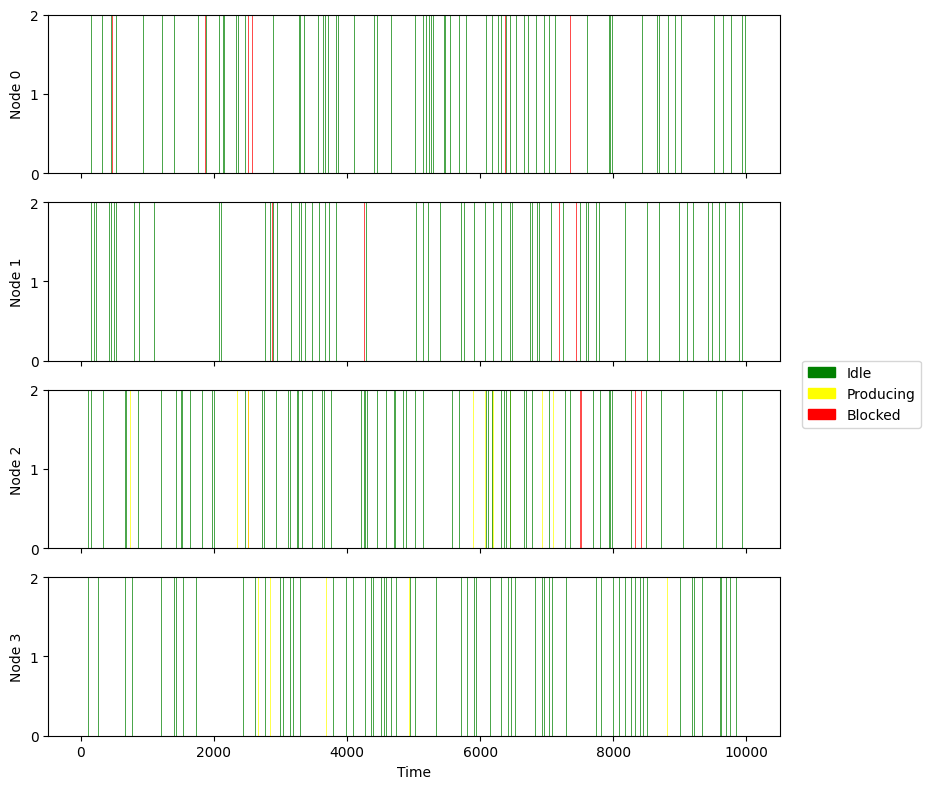

In [146]:
# Create a figure and axis for each subplot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

# Sample time series data
time_0 = graph.log[graph.log['node'] == 0]['time']
time_1 = graph.log[graph.log['node'] == 1]['time']
time_2 = graph.log[graph.log['node'] == 2]['time']
time_3 = graph.log[graph.log['node'] == 3]['time']

data_0 = graph.log[graph.log['node'] == 0]['state']
data_1 = graph.log[graph.log['node'] == 1]['state']
data_2 = graph.log[graph.log['node'] == 2]['state']
data_3 = graph.log[graph.log['node'] == 3]['state']

graph.log[graph.log['node'] == 0]['state']

# Define color mapping
colors = {0: 'green', 1: 'yellow', 2: 'red'}

# Plot each time series with colored backgrounds
for ax, time, data, label in zip(axs, [time_0, time_1, time_2, time_3], [data_0, data_1, data_2, data_3], ['Node 0', 'Node 1', 'Node 2', 'Node 3']):
    for t, state in zip(time, data):
        ax.axvspan(t - 0.5, t + 0.5, facecolor=colors[state], alpha=0.7)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['0', '1', '2'])
    ax.set_ylabel(label)
    
# Add legend
legend_labels = {'0': 'Producing', '1': 'Idle', '2': 'Blocked'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[int(label)]) for label in legend_labels.keys()]
fig.legend(legend_handles, legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5))

# Set common xlabel
plt.xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()